In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip

In [2]:
class CameraCalibration:
    
    def __init__(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....
        self.objp = np.zeros((6*9,3), np.float32)
        self.objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.
        self.found = 0 #Flag for counting the images with succesfull corner detection
        self.lost = 0 #Flag for counting the images with failed corner detection
        self.calib_paramtrs = {}
        self.ud_images = [] #List to store undistorted images
        
    def calibrate(self,images,test_image,output_path):
        for i,fname in enumerate(images):
            oimage = str(fname).split('/')[-1].split(".")[0]
            image = cv2.imread(fname)
            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            
            # Finding the chessboard corners
            
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
            
            # If found, append object points, image points to the lists
            if ret == True:
                self.objpoints.append(self.objp)
                self.imgpoints.append(corners)

            # Draw and display the corners
                image = cv2.drawChessboardCorners(image, (9,6), corners, ret)
                cv2.imshow('image',image)
                cv2.waitKey(300)
                op_fname= output_path + str(oimage) + str(i)+'.jpg'
            # Save the images with drawn corners
                cv2.imwrite(op_fname,image)
                self.found += 1
            else:
                self.lost += 1 
        print("Found : {0}".format(self.found))
        print("Lost : {0}".format(self.lost))
        cv2.destroyAllWindows()
        img = cv2.imread(test_image)
        img_size = (img.shape[1],img.shape[0])
        ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(self.objpoints,self.imgpoints,img_size,None, None)
        return mtx,img,dist
    
    def undistort(self,mtx,img,dist,test):
        dst = cv2.undistort(img,mtx,dist,None,mtx)
        
    #Displaying subplots
        if test == 1:
            try:
                cv2.imwrite('camera_calibration/test_out/test_undist.jpg',dst)
            except:
                raise Exception("Saving to test folder failed")
                
            dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
            ax1.imshow(img)
            ax1.set_title('Original Image', fontsize=20)
            ax2.imshow(dst)
            ax2.set_title('Undistorted Image', fontsize=20)
        else:
            return dst

    #Saving to pickle file
    
    def camsave(self,mtx,dist,pickle_path):
        self.calib_paramtrs['mtx'] = mtx
        self.calib_paramtrs['dist']= dist
        try:
            pickle.dump(self.calib_paramtrs,open(pickle_path,"wb"))
        except:
            raise Exception("Saving to pickle file failed")


In [3]:
class Transformer:
    
    def __init__(self):
        pass
    
    def sobel_xy(self,gray,kernel_size = 7):
#function to perform basic sobel operation on x and y to be used on magnitude and diretion functions
        sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0,kernel_size)
        sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,kernel_size)
        return sobelx,sobely
    
    def sobel_thresholded_abs(self,gray,kernel_size = 7,threshold = (0,255),orient = 'x'):
#function to perform sobel on x and y sepeartly with threshold
        if orient == 'x':
            sobel = cv2.Sobel(gray,cv2.CV_64F, 1, 0)
        elif orient =='y':
            sobel = cv2.Sobel(gray,cv2.CV_64F, 0, 1)
        else:
            raise Exception("Gradient orientation error")
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))
        sobel_binary = np.zeros((scaled_sobel.shape))
        sobel_binary[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
        return sobel_binary
    def magnitude_threshold(self,sobelx,sobely,kernel_size,mag_threshold = (0,255)):
        
    #calculating the gradient magnitude
        magnitude = np.sqrt(sobelx**2 + sobely**2)
    #scaling the magnitude with maximum value and converting to 8 bit
        scaled_magnitude = np.uint8(255*magnitude/np.max(magnitude))
        mag_binary = np.zeros((scaled_magnitude.shape))
        mag_binary[(scaled_magnitude >= mag_threshold[0]) & (scaled_magnitude <= mag_threshold[1])]
        return mag_binary
    
    def direction_threshold(self,sobelx,sobely,kernel_size,dir_threshold = (0,np.pi/2)):
        
        abs_grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        dir_binary = np.zeros((abs_grad_dir.shape))
        dir_binary[(abs_grad_dir >= dir_threshold[0]) & (abs_grad_dir <= dir_threshold[1])]
        return dir_binary
        
        
    def gradient_threshold(self,image,kernel_size = 7,xthreshold = (10,255),
                           ythreshold = (60,255),dir_threshold = (0,np.pi/2),mag_threshold = (60,255)):
    
    #Apply a threshold to the overall magnitude of the gradient, in both x and y.
    #The magnitude, or absolute value, of the gradient is just the square root
    #of the squares of the individual x and y gradients. 
    #For a gradient in both the x and y directions, 
    #the magnitude is the square root of the sum of the squares.
        
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

        gradx = self.sobel_thresholded_abs(gray,kernel_size,xthreshold,orient = 'x')
        grady = self.sobel_thresholded_abs(gray,kernel_size,ythreshold,orient = 'y')
        
        sx,sy = self.sobel_xy(gray,kernel_size)
        
        magnitude = self.magnitude_threshold(sx,sy,kernel_size,mag_threshold)
        direction = self.direction_threshold(sx,sy,kernel_size,dir_threshold)
        
        final_binary = np.zeros((gradx.shape))
        final_binary[((gradx == 1) & (grady == 1)) | ((magnitude == 1) & (direction == 1))] = 1
       
        return final_binary 
    
    def color_transform(self,image,t_clr = (0,255)):
        HLS = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
        S = HLS[:,:,2]
        s_th_binary = np.zeros((S.shape))
        s_th_binary[(S >= t_clr[0]) & (S <= t_clr[1])] = 1
        return s_th_binary
    
    def combine_image(self,gradout,color_space):
        combined_binary = np.zeros((gradout.shape))
        combined_binary[(gradout == 1) | (color_space == 1)] = 1
        return combined_binary
        
    def birdseyeview(self,image):
        height = image.shape[0] #720
        width = image.shape[1]#1280
        
        corner_lt =  [width // 2 - 76, height * 0.625]
        corner_rt = [width // 2 + 76, height * 0.625]
        corner_lb = [-100, height]
        corner_rb = [width + 100, height]
        src_points = np.float32([corner_lt,corner_rt,corner_lb,corner_rb])
        
        d1 = [100, 0]
        d2 = [width - 100, 0]
        d3 = [100, height]
        d4 = [width - 100, height]
        dst_points = np.float32([d1, d2, d3, d4])
        
        M = cv2.getPerspectiveTransform(src_points, dst_points)   
        warped = cv2.warpPerspective(image, M, (width, height))
        unwarp_m = cv2.getPerspectiveTransform(dst_points, src_points) 
        unwarped = cv2.warpPerspective(image, unwarp_m, (width, height))
        
        return warped, unwarped,unwarp_m
        
    def ploting(self,image,combined_binary,gradout,color_space):
        img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        f,(ax1, ax2) = plt.subplots(1,2,figsize = (20,20))
        a,(ax3,ax4) = plt.subplots(1,2,figsize = (20,20)) 
        ax1.set_title("Original Image")
        ax1.imshow(img)
        ax2.set_title("Gradient Threshold")
        ax2.imshow(gradout,cmap = 'gray')
        ax3.set_title("Color Threshold")
        ax3.imshow(color_space,cmap= 'gray')
        ax4.set_title("Combined Image")
        ax4.imshow(combined_binary,cmap= 'gray')
        
    def run(self,image):
        gradout = self.gradient_threshold(image,kernel_size = 7,xthreshold = (10,255),
                           ythreshold = (60,255),dir_threshold = (0,np.pi/2),mag_threshold = (60,255))
        color_space  = self.color_transform(image,t_clr = (120,255))
        combined_binary = self.combine_image(gradout,color_space)
        warped,unwarped,unwarp_m =  self.birdseyeview(combined_binary)
        
        return warped,unwarped,unwarp_m


In [7]:
class LaneFinder:
    
    def __init__(self):
        self.left_line = np.zeros((3,))
        self.right_line = np.zeros((3,))
        self.leftline_detected = False
        self.rightline_detected = False
        
    def histogram(self,warped):
        bottom_half = warped[warped.shape[0]//2:,:]
        histogram = np.sum(bottom_half,axis = 0)
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        return leftx_base,rightx_base

            
    def lane_pixel_finder(self,leftx_base,rightx_base,warped):
    #Setting the hyper parameters
        num_windows = 9
        margin = 100
        minimum_pxls = 50
        window_height = np.int(warped.shape[0]//num_windows)
        height = warped.shape[0]
        width = warped.shape[1]
        
    #Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        out_img = np.uint8(np.dstack((warped,warped,warped))*255)       
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
    
    # Current position of bases
        current_leftx = leftx_base
        current_rightx = rightx_base
            
        for window in range(num_windows):
            ylow_window = height - (window + 1)*window_height
            yhigh_window = height - (window*window_height)
            xlow_window_left = current_leftx - margin
            xhigh_window_left = current_leftx + margin
            xlow_window_right = current_rightx  - margin
            xhigh_window_right = current_rightx + margin  
                
    #Visualizing the windows
    
            cv2.rectangle(out_img,(xlow_window_left,ylow_window),
            (xhigh_window_left,yhigh_window),(0,255,0), 2) 
            cv2.rectangle(out_img,(xlow_window_right,ylow_window),
            (xhigh_window_right,yhigh_window),(0,255,0), 2)

            left_indexes = ((nonzeroy >= ylow_window) & (nonzeroy <= yhigh_window)
                & (nonzerox >= xlow_window_left) & (nonzerox <= xhigh_window_left)).nonzero()[0]
            right_indexes = ((nonzeroy >= ylow_window) & (nonzeroy <= yhigh_window)
                & (nonzerox >= xlow_window_right) & (nonzerox <= xhigh_window_right)).nonzero()[0]
                              
        # Append these indices to the lists
        
            left_lane_inds.append(left_indexes)
            right_lane_inds.append(right_indexes)
                
            if len(left_indexes) > minimum_pxls:
                current_leftx = np.int(np.mean(nonzerox[left_indexes]))
            if len(right_indexes) > minimum_pxls:        
                current_rightx = np.int(np.mean(nonzerox[right_indexes]))
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
        # Avoids an error if the above is not implemented fully
                pass
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        return leftx,lefty,rightx,righty,out_img
    
    def line_fit(self,leftx,lefty,rightx,righty,out_img):
    # To perform poly fit
        ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
        self.left_line = np.polyfit(lefty,leftx,2)
        self.right_line = np.polyfit(righty,rightx,2)
        self.leftline_detected = True
        self.rightline_detected = True
        
        try:
            left_fitx = self.left_line[0]*ploty**2 + self.left_line[1]*ploty + self.left_line[2]
            right_fitx = self.right_line[0]*ploty**2 + self.right_line[1]*ploty + self.right_line[2] 
        except TypeError:
        # Avoids an error if `left_line` and `right_line` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
                
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    
        #plt.plot(left_fitx, self.ploty, color='yellow')
        #plt.plot(right_fitx, self.ploty, color='yellow')

        return out_img,left_fitx,right_fitx,ploty
    def check_poly(self,warped):
        
        margin = 100
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        out_img = np.dstack((warped, warped, warped))
        
        left_indexes = ((nonzerox > (self.left_line[0]*(nonzeroy**2) + self.left_line[1]*nonzeroy + 
                    self.left_line[2] - margin)) & (nonzerox < (self.left_line[0]*(nonzeroy**2) + 
                    self.left_line[1]*nonzeroy + self.left_line[2] + margin)))
        right_indexes = ((nonzerox > (self.right_line[0]*(nonzeroy**2) + self.right_line[1]*nonzeroy + 
                    self.right_line[2] - margin)) & (nonzerox < (self.right_line[0]*(nonzeroy**2) + 
                    self.right_line[1]*nonzeroy + self.right_line[2] + margin)))
        
        leftx = nonzerox[left_indexes]
        lefty = nonzeroy[left_indexes] 
        rightx = nonzerox[right_indexes]
        righty = nonzeroy[right_indexes]
        return leftx,lefty,rightx,righty,out_img 
    
    def curvature(self,left_fitx,right_fitx,ploty):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700
        left_radius_fit = np.polyfit((ym_per_pix * ploty), (xm_per_pix * left_fitx),2)
        right_radius_fit = np.polyfit(ym_per_pix * ploty, xm_per_pix * right_fitx,2)
        ymax = np.max(ploty)
        left_radius =((1 + (2*left_radius_fit[0]*ymax + left_radius_fit[1])**2)**1.5) / np.absolute(2*left_radius_fit[0])
        right_radius = ((1 + ((2*self.right_line[0]*ymax) + self.right_line[1])**2)**1.5) / np.absolute(2*self.right_line[0])
        return left_radius,right_radius
    
    def fill_poly(self,left_xpoints,right_xpoints,warped,image,unwarp_m,ploty): #ypoints is defined as class member variable
        
#creating an image to draw the line
        draw_image = np.zeros((warped.shape[0],warped.shape[1]))
        draw_image = np.dstack((draw_image,draw_image,draw_image))
        ypoints = ploty
        leftlane_points = (np.array([np.transpose(np.vstack([left_xpoints,ypoints]))]))
        rightlane_points = (np.array([np.flipud(np.transpose(np.vstack([right_xpoints,ypoints])))]))
        contours = np.hstack((leftlane_points,rightlane_points))
        img = np.int_(image)
        cv2.fillPoly(draw_image, pts = np.int_([contours]),color =(0,0,255))
        unwarped_out = cv2.warpPerspective(draw_image, unwarp_m, (image.shape[1], image.shape[0]))
        un = np.int_(unwarped_out)
        final_out = cv2.addWeighted(img,0.5,un,0.5,0)
        return final_out,unwarped_out
    
    def vehicle_position(self,pts,image):
        center = image.shape[1]//2
        left = np.min(pts[:,1])
        right = np.max(pts[:,1])
        pos = (left + right)/2
        position = (center - pos)*(3.7/700)
        return (position)
    
    def run(self,warped,unwarp_m,image):
        leftx_base,rightx_base = self.histogram(warped)
        if ((self.leftline_detected == True) & (self.rightline_detected == True)):
            leftx,lefty,rightx,righty,out_img = self.check_poly(warped)
        else:
            leftx,lefty,rightx,righty,out_img = self.lane_pixel_finder(leftx_base,rightx_base,warped)
        out_img,left_fitx,right_fitx,ploty = self.line_fit(leftx,lefty,rightx,righty,out_img)
        final_out,unwarped_out = self.fill_poly(left_fitx,right_fitx,warped,image,unwarp_m,ploty)
        pts = np.argwhere(unwarped_out[:,:,2])
        position = self.vehicle_position(pts,out_img)
        left_radius,right_radius = self.curvature(left_fitx,right_fitx,ploty)
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = "Radius of Curvature: {} m".format(int(left_radius))
        pos_text = "Vehicle position from centre : {:.3f} m".format(position)
        cv2.putText(final_out,text,(400,100), font, 1,(255,255,255),2)
        if position < 0:
            pos_text = "Vehicle is {:.2f} m left of center".format(-position)
        else:
            pos_text = "Vehicle is {:.2f} m right of center".format(position)
        cv2.putText(final_out,pos_text,(400,140), font, 1,(255,255,0),2)
        
        return final_out


In [8]:
class Loader:
    
    def __init__(self,calib_images,test_image,calib_output_path,input_path,out_path,pickle_path):
        self.camera_load = False
        self.camera = CameraCalibration()
        self.calib_images = calib_images
        self.test_image = test_image
        self.calib_output_path = calib_output_path
        self.input_path = input_path
        self.out_path = out_path
        self.pickle_path = pickle_path
        self.dist,self.mtx = self.load_camera()
        self.transform = Transformer()
        self.laneline = LaneFinder()
        
        
    def load_camera(self):
        try:
            with open(self.pickle_path, 'rb') as file:
                data = pickle.load(file)
                self.camera_load = True
            dist = data['dist']
            mtx = data['mtx']
            img = cv2.imread(self.test_image)
            self.camera.undistort(mtx,img,dist,test = 1)
            print("Camera is already calibrated and Camera Parameters are loaded succesfully")
        except:
            print("Camera is not yet calibrated and Camera is calibrating now")
            mtx,img,dist = self.camera.calibrate(self.calib_images,self.test_image,self.calib_output_path)
            self.camera.undistort(mtx,img,dist,test = 1)
            self.camera_load = True
            self.camera.camsave(mtx,dist,self.pickle_path)
            print("Camera is calibrated and Camera parameters are succesfully saved for later use")
        return dist,mtx
    
    def process_frame(self,image):
        img = self.camera.undistort(self.mtx,image,self.dist,test = 0)
        warped,unwarped,unwarp_m = self.transform.run(img)
        final_out = self.laneline.run(warped,unwarp_m,img)
        return final_out  
    
    def image_loader(self,image_path):
    #function to load images
        images = []
        fnames = glob.glob(image_path)
        for i,image in enumerate(fnames):
            if i == 1:
                img = cv2.imread(image)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
        return img
    
    def video_loader(self,video_path,output):
    
        clip = VideoFileClip(video_path).subclip(0,2)
        frame = clip.fl_image(self.process_frame) # This process_frame function should return an image 
        %time frame.write_videofile(output, audio=False)
    

Camera is already calibrated and Camera Parameters are loaded succesfully


t:   0%|          | 0/50 [00:00<?, ?it/s, now=None]

Moviepy - Building video /home/jibin/Documents/codes/Advanced-Lane-Lines/examples/output_9.mp4.
Moviepy - Writing video /home/jibin/Documents/codes/Advanced-Lane-Lines/examples/output_9.mp4



Moviepy - Done !
Moviepy - video ready /home/jibin/Documents/codes/Advanced-Lane-Lines/examples/output_9.mp4
CPU times: user 17.3 s, sys: 4.6 s, total: 21.9 s
Wall time: 10.6 s


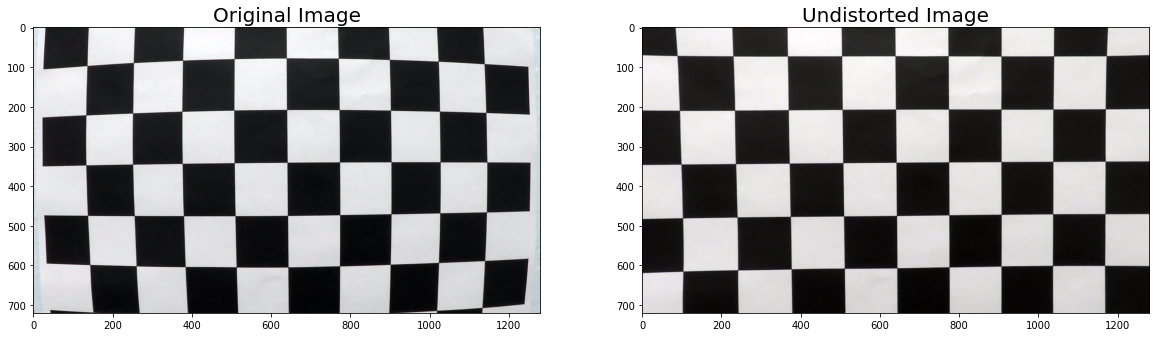

In [9]:
      
if __name__ == "__main__":
    
#calibration inputs   
    calib_images = glob.glob('/home/jibin/Documents/codes/Advanced-Lane-Lines/camera_cal/calibration*.jpg')
    calib_output_path = '/home/jibin/Documents/codes/Advanced-Lane-Lines/camera_cal/calibration_out/'
    test_image = '/home/jibin/Documents/codes/Advanced-Lane-Lines/camera_cal/calibration1.jpg'
    
#Image feed inputs
    input_path ='/home/jibin/Documents/codes/Advanced-Lane-Lines/test_images/*.jpg'
    out_path = '/home/jibin/Documents/codes/Advanced-Lane-Lines/output_images/'
    
#Video feed input
    video_path = "/home/jibin/Documents/codes/Advanced-Lane-Lines/project_video.mp4"

# Video out path
    video_out = '/home/jibin/Documents/codes/Advanced-Lane-Lines/examples/output_9.mp4'
    
#pickle load file path
    pickle_path = "/home/jibin/Documents/codes/Advanced-Lane-Lines/examples/camera_calibration/calib_parameters_pickle.p"
    
    load = Loader(calib_images,test_image,calib_output_path,input_path,out_path,pickle_path)
    load.video_loader(video_path,video_out)
    
# Following lines of code for testing images
    
    #load_image = load.image_loader(input_path)
    #process_frame(load_image)